In [26]:
import scipy.io as scio
import matplotlib.pyplot as plt
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data']
# 提取第一行（第一通道的EEG数据）
first_channel = matrix_data[0, :]
sampled_data = first_channel[:50000:10]

In [27]:
len(sampled_data)

5000

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 128, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 1, 128, 8)         512       
                                                                 
 batch_normalization (BatchN  (None, 1, 128, 8)        32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 128, 16)       16        
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 128, 16)       64        
 hNormalization)                                                 
                                                             

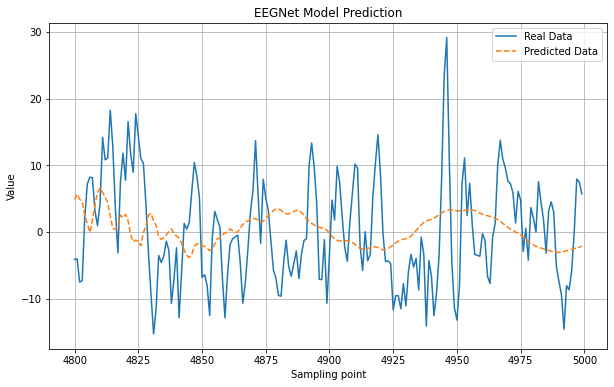

In [3]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D, 
                                     BatchNormalization, Activation, AveragePooling2D, 
                                     SpatialDropout2D, Flatten, Dense)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# 固定随机种子
np.random.seed(23)
tf.random.set_seed(24)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:5000]  # 假设 'sampled_data' 包含 5000 个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 128  # 设置时间步长，适合 EEGNet 模型的结构
X, y = [], []

# 构建输入和标签数据
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i + n_steps])
    y.append(train_data[i + n_steps])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], 1, n_steps, 1))  # 适应 EEGNet 输入的格式

# 构建 EEGNet 模型
def EEGNet(nb_classes=1, Chans=1, Samples=128, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16):
    input1 = Input(shape=(Chans, Samples, 1))

    # Block 1: Temporal Convolution
    x = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, 
                        depthwise_constraint=tf.keras.constraints.max_norm(1.))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = SpatialDropout2D(dropoutRate)(x)

    # Block 2: Separable Convolution
    x = SeparableConv2D(F2, (1, 16), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 8))(x)
    x = SpatialDropout2D(dropoutRate)(x)

    # Flatten and Dense Layer
    x = Flatten()(x)
    x = Dense(nb_classes)(x)
    
    return Model(inputs=input1, outputs=x)

# 构建并编译模型
model = EEGNet(nb_classes=1, Chans=1, Samples=n_steps)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 打印模型结构
model.summary()

# 设置训练回调
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# 训练模型
epochs = 100
history = model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, callbacks=[early_stopping, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, 1, n_steps, 1))  # 取最后 128 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)
    predicted_points.append(predicted[0, 0])

    # 更新滑动窗口
    X_input = np.append(X_input[:, :, 1:, :], [[[[predicted[0, 0]]]]], axis=2)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('EEGNet Model Prediction')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 128, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 128, 8)         512       
                                                                 
 batch_normalization_3 (Batc  (None, 1, 128, 8)        32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 1, 128, 16)       16        
 seConv2D)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 1, 128, 16)       64        
 hNormalization)                                                 
                                                           

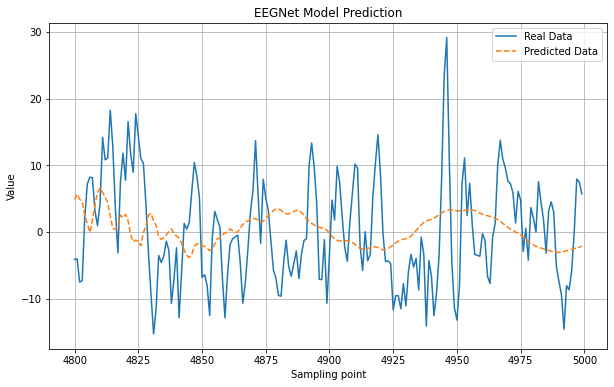

In [4]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D, 
                                     BatchNormalization, Activation, AveragePooling2D, 
                                     SpatialDropout2D, Flatten, Dense)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# 固定随机种子
np.random.seed(23)
tf.random.set_seed(24)

# 数据标准化
scaler = StandardScaler()  
sampled_data = sampled_data[:5000]  # 假设 'sampled_data' 包含 5000 个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 128  # 设置时间步长，适合 EEGNet 模型的结构
X, y = [], []

# 构建输入和标签数据
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i + n_steps])
    y.append(train_data[i + n_steps])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], 1, n_steps, 1))  # 适应 EEGNet 输入的格式

# 构建 EEGNet 模型
def EEGNet(nb_classes=1, Chans=1, Samples=128, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16):
    input1 = Input(shape=(Chans, Samples, 1))

    # Block 1: Temporal Convolution
    x = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, 
                        depthwise_constraint=tf.keras.constraints.max_norm(1.))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = SpatialDropout2D(dropoutRate)(x)

    # Block 2: Separable Convolution
    x = SeparableConv2D(F2, (1, 16), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 8))(x)
    x = SpatialDropout2D(dropoutRate)(x)

    # Flatten and Dense Layer
    x = Flatten()(x)
    x = Dense(nb_classes)(x)
    
    return Model(inputs=input1, outputs=x)

# 构建并编译模型
model = EEGNet(nb_classes=1, Chans=1, Samples=n_steps)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 打印模型结构
model.summary()

# 设置训练回调
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# 训练模型
epochs = 100
history = model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, callbacks=[early_stopping, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, 1, n_steps, 1))  # 取最后 128 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)
    predicted_points.append(predicted[0, 0])

    # 更新滑动窗口
    X_input = np.append(X_input[:, :, 1:, :], [[[[predicted[0, 0]]]]], axis=2)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('EEGNet Model Prediction')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


Training Progress:  44%|██████████████████████████▉                                   | 87/200 [01:45<02:17,  1.21s/it]


Training completed in 105.66 seconds
均方根误差 (RMSE): 8.2396


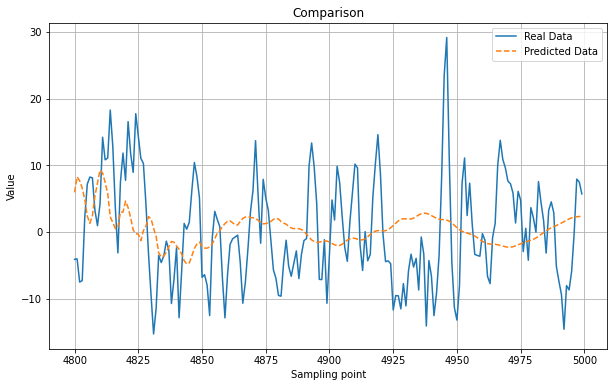

频谱相似度: 0.5934


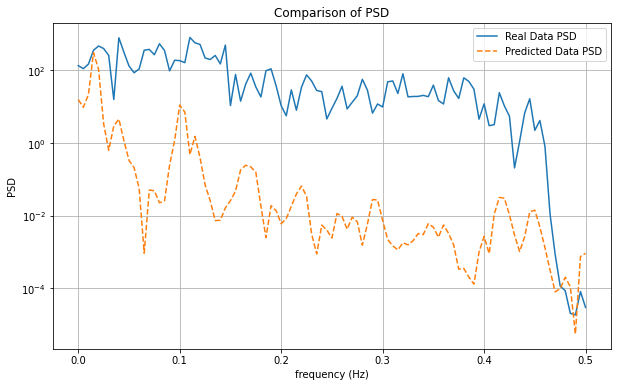

功率谱密度 (PSD) 相似度: 0.2702


In [6]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D, 
                                     BatchNormalization, Activation, AveragePooling2D, 
                                     SpatialDropout2D, Flatten, Dense)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import welch
from tqdm import tqdm
import time

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = MinMaxScaler(feature_range=(-1, 1))
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 128  # EEGNet的时间步长
X, y = [], []

# 构建输入和标签数据
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i + n_steps])
    y.append(train_data[i + n_steps])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], 1, n_steps, 1))  # 适应 EEGNet 输入的格式

# EEGNet模型
def EEGNet(nb_classes=1, Chans=1, Samples=128, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16):
    input1 = Input(shape=(Chans, Samples, 1))

    # Block 1: Temporal Convolution
    x = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, 
                        depthwise_constraint=tf.keras.constraints.max_norm(1.))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = SpatialDropout2D(dropoutRate)(x)

    # Block 2: Separable Convolution
    x = SeparableConv2D(F2, (1, 16), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 8))(x)
    x = SpatialDropout2D(dropoutRate)(x)

    # Flatten and Dense Layer
    x = Flatten()(x)
    x = Dense(nb_classes)(x)
    
    return Model(inputs=input1, outputs=x)

# 构建并编译模型
model = EEGNet(nb_classes=1, Chans=1, Samples=n_steps)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# 设置回调函数
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)
epochs = 200

# 训练进度条和时间跟踪
start_time = time.time()
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)
    
    # 模型训练
    history = model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, 
                        callbacks=[progress_callback, early_stopping, lr_scheduler])

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

# 用模型预测未来200个点
X_input = train_data[-n_steps:].reshape((1, 1, n_steps, 1))  # 取最后128个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)
    predicted_points.append(predicted[0, 0])
    
    # 更新滑动窗口
    X_input = np.append(X_input[:, :, 1:, :], predicted[0, 0].reshape(1, 1, 1, 1), axis=2)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data PSD')
plt.semilogy(f_pred, psd_pred, label='Predicted Data PSD', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
146/146 [==============================] - 1s 4ms/step - loss: 0.2448 - lr: 0.0010
Epoch 2/200
146/146 [==============================] - 1s 4ms/step - loss: 0.1028 - lr: 0.0010
Epoch 3/200
146/146 [==============================] - 1s 4ms/step - loss: 0.0808 - lr: 0.0010
Epoch 4/200
146/146 [==============================] - 1s 4ms/step - loss: 0.0712 - lr: 0.0010
Epoch 5/200
146/146 [==============================] - 1s 4ms/step - loss: 0.0634 - lr: 0.0010
Epoch 6/200
146/146 [==============================] - 1s 4ms/step - loss: 0.0599 - lr: 0.0010
Epoch 7/200
146/146 [==============================] - 1s 4ms/step - loss: 0.0569 - lr: 0.0010
Epoch 8/200
146/146 [==============================] - 1s 4ms/step - loss: 0.0531 - lr: 0.0010
Epoch 9/200
146/146 [==============================] - 1s 4ms/step - loss: 0.0519 - lr: 0.0010
Epoch 10/200
146/146 [==============================] - 1s 4ms/step - loss: 0.0479 - lr: 0.0010
Epoch 11/200
146/146 [===========================

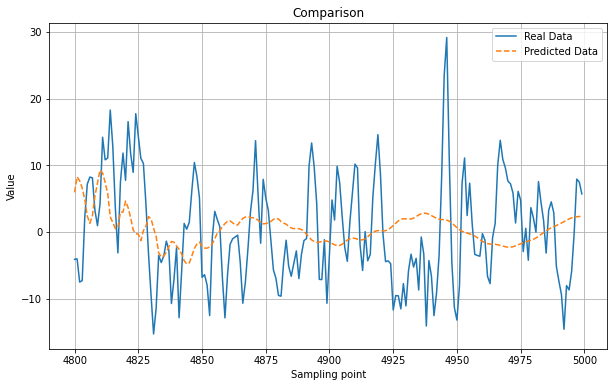

频谱相似度: 0.5934


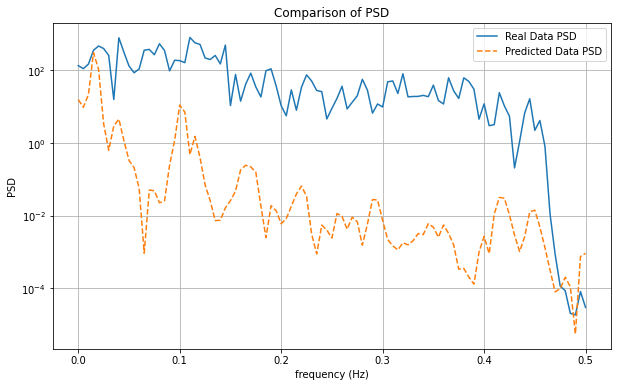

功率谱密度 (PSD) 相似度: 0.2702


In [7]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D, 
                                     BatchNormalization, Activation, AveragePooling2D, 
                                     SpatialDropout2D, Flatten, Dense)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import welch
import time

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = MinMaxScaler(feature_range=(-1, 1))
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 128  # EEGNet的时间步长
X, y = [], []

# 构建输入和标签数据
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i + n_steps])
    y.append(train_data[i + n_steps])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], 1, n_steps, 1))  # 适应 EEGNet 输入的格式

# EEGNet模型
def EEGNet(nb_classes=1, Chans=1, Samples=128, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16):
    input1 = Input(shape=(Chans, Samples, 1))

    # Block 1: Temporal Convolution
    x = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, 
                        depthwise_constraint=tf.keras.constraints.max_norm(1.))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = SpatialDropout2D(dropoutRate)(x)

    # Block 2: Separable Convolution
    x = SeparableConv2D(F2, (1, 16), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 8))(x)
    x = SpatialDropout2D(dropoutRate)(x)

    # Flatten and Dense Layer
    x = Flatten()(x)
    x = Dense(nb_classes)(x)
    
    return Model(inputs=input1, outputs=x)

# 构建并编译模型
model = EEGNet(nb_classes=1, Chans=1, Samples=n_steps)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# 设置回调函数
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)
epochs = 200

# 训练模型
start_time = time.time()
history = model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, 
                    callbacks=[early_stopping, lr_scheduler])
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

# 用模型预测未来200个点
X_input = train_data[-n_steps:].reshape((1, 1, n_steps, 1))  # 取最后128个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)
    predicted_points.append(predicted[0, 0])
    
    # 更新滑动窗口
    X_input = np.append(X_input[:, :, 1:, :], predicted[0, 0].reshape(1, 1, 1, 1), axis=2)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data PSD')
plt.semilogy(f_pred, psd_pred, label='Predicted Data PSD', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
150/150 [==============================] - 4s 14ms/step - loss: 0.1339 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 2s 14ms/step - loss: 0.0525 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 2s 14ms/step - loss: 0.0486 - lr: 0.0010
Epoch 4/200
150/150 [==============================] - 2s 14ms/step - loss: 0.0451 - lr: 0.0010
Epoch 5/200
150/150 [==============================] - 3s 19ms/step - loss: 0.0425 - lr: 0.0010
Epoch 6/200
150/150 [==============================] - 3s 20ms/step - loss: 0.0417 - lr: 0.0010
Epoch 7/200
150/150 [==============================] - 3s 20ms/step - loss: 0.0407 - lr: 0.0010
Epoch 8/200
150/150 [==============================] - 3s 19ms/step - loss: 0.0400 - lr: 0.0010
Epoch 9/200
150/150 [==============================] - 3s 20ms/step - loss: 0.0403 - lr: 0.0010
Epoch 10/200
150/150 [==============================] - 3s 19ms/step - loss: 0.0404 - lr: 0.0010
Epoch 11/200
150/150 [=================

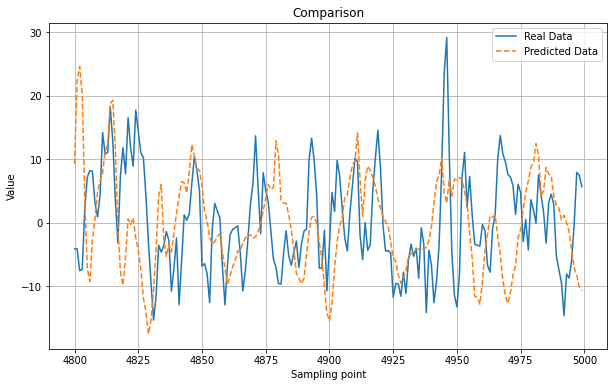

频谱相似度: 0.7492


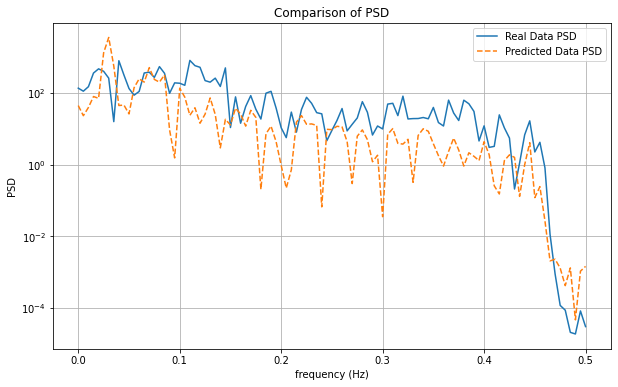

功率谱密度 (PSD) 相似度: 0.2948


In [9]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy.signal import welch
from sklearn.preprocessing import MinMaxScaler
import time

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = MinMaxScaler(feature_range=(-1, 1))
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 30  # 时间步长
X, y = [], []

# 构建输入和标签数据
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i + n_steps])
    y.append(train_data[i + n_steps])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为LSTM输入格式

# 构建双层LSTM模型
def build_lstm_model(input_shape, units=64):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape, activation='tanh'))
    model.add(BatchNormalization())
    model.add(LSTM(units, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(1))
    return model

# 构建并编译模型
model = build_lstm_model((n_steps, 1))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# 设置回调函数
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)
epochs = 200

# 模型训练
start_time = time.time()
history = model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, 
                    callbacks=[early_stopping, lr_scheduler])
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

# 用模型预测未来200个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后n_steps个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)
    predicted_points.append(predicted[0, 0])

    # 更新滑动窗口
    X_input = np.append(X_input[:, 1:, :], predicted[0, 0].reshape(1, 1, 1), axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data PSD')
plt.semilogy(f_pred, psd_pred, label='Predicted Data PSD', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
150/150 [==============================] - 1s 2ms/step - loss: 0.8037 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 0s 2ms/step - loss: 0.3311 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 0s 2ms/step - loss: 0.2074 - lr: 0.0010
Epoch 4/200
150/150 [==============================] - 0s 2ms/step - loss: 0.1387 - lr: 0.0010
Epoch 5/200
150/150 [==============================] - 0s 2ms/step - loss: 0.1056 - lr: 0.0010
Epoch 6/200
150/150 [==============================] - 0s 2ms/step - loss: 0.0843 - lr: 0.0010
Epoch 7/200
150/150 [==============================] - 0s 2ms/step - loss: 0.0704 - lr: 0.0010
Epoch 8/200
150/150 [==============================] - 0s 2ms/step - loss: 0.0620 - lr: 0.0010
Epoch 9/200
150/150 [==============================] - 0s 2ms/step - loss: 0.0579 - lr: 0.0010
Epoch 10/200
150/150 [==============================] - 0s 2ms/step - loss: 0.0547 - lr: 0.0010
Epoch 11/200
150/150 [===========================

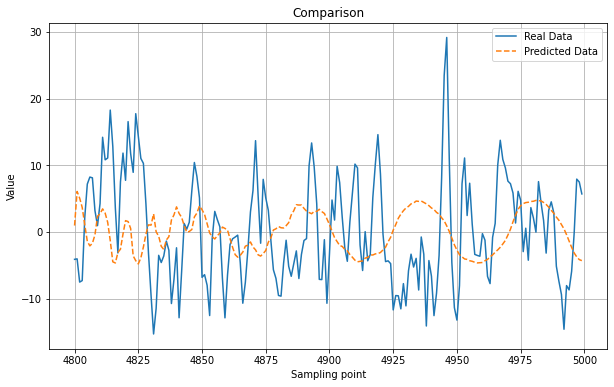

频谱相似度: 0.6603


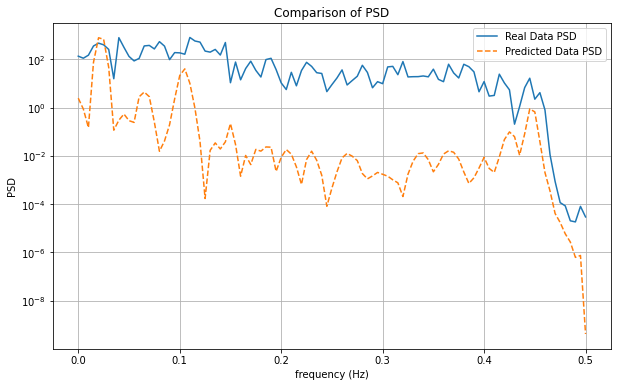

功率谱密度 (PSD) 相似度: 0.3359


In [22]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, DepthwiseConv2D, Dense, BatchNormalization, Activation, AveragePooling1D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy.signal import welch
from sklearn.preprocessing import MinMaxScaler
import time

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = MinMaxScaler(feature_range=(-1, 1))
sampled_data = sampled_data[:5000]
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 30
X, y = [], []

# 构建输入和标签数据
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i + n_steps])
    y.append(train_data[i + n_steps])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为一维输入格式

# 构建改进的EEGNet模型
def build_eegnet_model(input_shape):
    inputs = Input(shape=input_shape)

    # 第一层卷积
    x = Conv1D(8, 16, padding='same', activation=None, use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # 第二层深度卷积
    x = Reshape((input_shape[0], 1, 8))(x)
    x = DepthwiseConv2D((input_shape[0], 1), use_bias=False, depth_multiplier=2, depthwise_constraint=tf.keras.constraints.max_norm(1.))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Dropout(0.5)(x)

    # 第三层卷积
    x = Reshape((-1, x.shape[-1] * x.shape[-2]))(x)
    x = Conv1D(16, 8, padding='same', activation=None, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Dropout(0.5)(x)

    # 全连接层
    x = Flatten()(x)
    x = Dense(1)(x)

    model = Model(inputs, x)
    return model





# 构建模型
model = build_eegnet_model((n_steps, 1))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# 早停机制和学习率调度
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)
epochs = 200

# 模型训练
start_time = time.time()
history = model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=1, 
                    callbacks=[early_stopping, lr_scheduler])
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

# 用模型预测未来200个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后n_steps个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)
    predicted_points.append(predicted[0, 0])

    # 更新滑动窗口
    X_input = np.append(X_input[:, 1:, :], predicted[0, 0].reshape(1, 1, 1), axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data PSD')
plt.semilogy(f_pred, psd_pred, label='Predicted Data PSD', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Epoch 1/200
150/150 [==============================] - 1s 3ms/step - loss: 1.5402 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5350 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 1s 3ms/step - loss: 0.2716 - lr: 0.0010
Epoch 4/200
150/150 [==============================] - 0s 3ms/step - loss: 0.1703 - lr: 0.0010
Epoch 5/200
150/150 [==============================] - 0s 3ms/step - loss: 0.1208 - lr: 0.0010
Epoch 6/200
150/150 [==============================] - 0s 3ms/step - loss: 0.0959 - lr: 0.0010
Epoch 7/200
150/150 [==============================] - 0s 3ms/step - loss: 0.0842 - lr: 0.0010
Epoch 8/200
150/150 [==============================] - 0s 3ms/step - loss: 0.0804 - lr: 0.0010
Epoch 9/200
150/150 [==============================] - 0s 3ms/step - loss: 0.0786 - lr: 0.0010
Epoch 10/200
150/150 [==============================] - 0s 3ms/step - loss: 0.0773 - lr: 0.0010
Epoch 11/200
150/150 [===========================

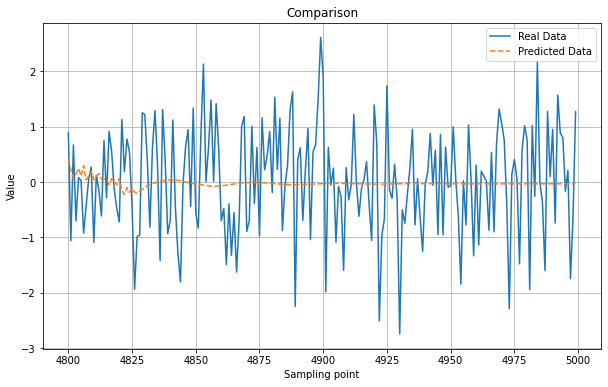

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, DepthwiseConv2D, BatchNormalization, Activation, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 固定随机种子
np.random.seed(24)
tf.random.set_seed(25)

# 数据预处理
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = np.random.randn(5000)  # 替换为你的5000个数据点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 30  # 时间步长
X, y = [], []
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i + n_steps])
    y.append(train_data[i + n_steps])

X, y = np.array(X), np.array(y)

# 构建复杂的 EEGNet 模型
def build_complex_eegnet_model(input_shape):
    inputs = Input(shape=input_shape)

    # 第一层卷积
    x = Conv1D(32, 8, padding='same', activation=None, use_bias=False, kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Dropout(0.3)(x)

    # 第二层深度卷积
    x = Reshape((input_shape[0], 1, 32))(x)
    x = DepthwiseConv2D((input_shape[0], 1), use_bias=False, depth_multiplier=2, depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Dropout(0.5)(x)

    # 第三层卷积
    x = Reshape((-1, x.shape[-1] * x.shape[-2]))(x)
    x = Conv1D(64, 4, padding='same', activation=None, use_bias=False, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Dropout(0.5)(x)

    # 增加一个卷积层来提高模型的复杂度
    x = Conv1D(128, 4, padding='same', activation=None, use_bias=False, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Dropout(0.5)(x)

    # 全连接层
    x = Flatten()(x)
    x = Dense(64, activation='elu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(1, kernel_regularizer=l2(1e-4))(x)

    model = Model(inputs, x)
    return model

# 定义模型
model = build_complex_eegnet_model((n_steps, 1))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# 设置学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

# 训练模型
epochs = 200
X = X.reshape((X.shape[0], X.shape[1], 1))
history = model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, callbacks=[early_stopping, lr_scheduler], verbose=1)

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)
    predicted_points.append(predicted[0][0])
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/200
150/150 [==============================] - 1s 3ms/step - loss: 1.5587 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 1s 3ms/step - loss: 0.5367 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 1s 3ms/step - loss: 0.2719 - lr: 0.0010
Epoch 4/200
150/150 [==============================] - 0s 3ms/step - loss: 0.1692 - lr: 0.0010
Epoch 5/200
150/150 [==============================] - 0s 3ms/step - loss: 0.1155 - lr: 0.0010
Epoch 6/200
150/150 [==============================] - 1s 3ms/step - loss: 0.0913 - lr: 0.0010
Epoch 7/200
150/150 [==============================] - 1s 3ms/step - loss: 0.0800 - lr: 0.0010
Epoch 8/200
150/150 [==============================] - 1s 3ms/step - loss: 0.0734 - lr: 0.0010
Epoch 9/200
150/150 [==============================] - 1s 3ms/step - loss: 0.0707 - lr: 0.0010
Epoch 10/200
150/150 [==============================] - 1s 3ms/step - loss: 0.0684 - lr: 0.0010
Epoch 11/200
150/150 [===========================

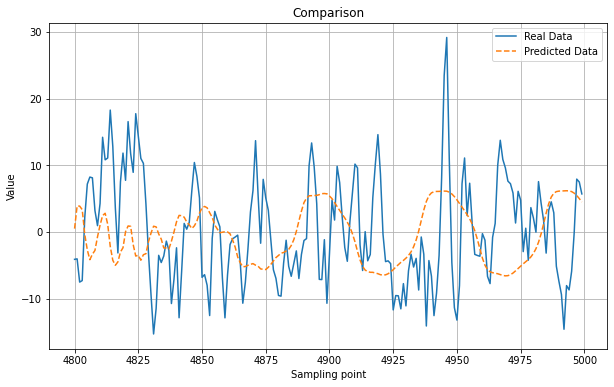

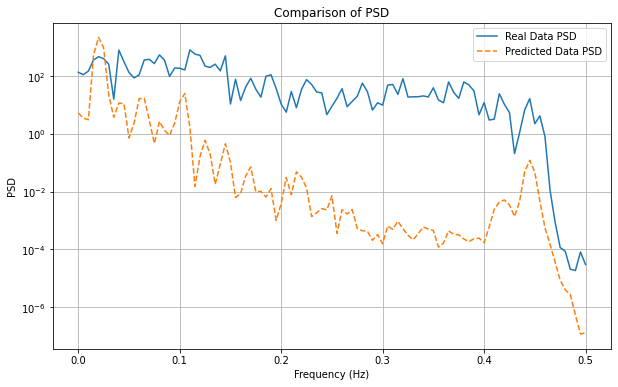

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, DepthwiseConv2D, BatchNormalization, Activation, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import welch
import matplotlib.pyplot as plt

# 固定随机种子
np.random.seed(24)
tf.random.set_seed(25)

# 数据预处理
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 30  # 时间步长
X, y = [], []
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i + n_steps])
    y.append(train_data[i + n_steps])

X, y = np.array(X), np.array(y)

# 构建复杂的 EEGNet 模型
def build_complex_eegnet_model(input_shape):
    inputs = Input(shape=input_shape)

    # 第一层卷积
    x = Conv1D(32, 8, padding='same', activation=None, use_bias=False, kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Dropout(0.3)(x)

    # 第二层深度卷积
    x = Reshape((input_shape[0], 1, 32))(x)
    x = DepthwiseConv2D((input_shape[0], 1), use_bias=False, depth_multiplier=2, depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Dropout(0.5)(x)

    # 第三层卷积
    x = Reshape((-1, x.shape[-1] * x.shape[-2]))(x)
    x = Conv1D(64, 4, padding='same', activation=None, use_bias=False, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Dropout(0.5)(x)

    # 增加一个卷积层来提高模型的复杂度
    x = Conv1D(128, 4, padding='same', activation=None, use_bias=False, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = Dropout(0.5)(x)

    # 全连接层
    x = Flatten()(x)
    x = Dense(64, activation='elu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(1, kernel_regularizer=l2(1e-4))(x)

    model = Model(inputs, x)
    return model

# 定义模型
model = build_complex_eegnet_model((n_steps, 1))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# 设置学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

# 训练模型
epochs = 200
X = X.reshape((X.shape[0], X.shape[1], 1))
history = model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, callbacks=[early_stopping, lr_scheduler], verbose=1)

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)
    predicted_points.append(predicted[0][0])
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data PSD')
plt.semilogy(f_pred, psd_pred, label='Predicted Data PSD', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/200
150/150 [==============================] - 2s 10ms/step - loss: 0.1752 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 1s 10ms/step - loss: 0.0783 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 2s 10ms/step - loss: 0.0777 - lr: 0.0010
Epoch 4/200
150/150 [==============================] - 1s 10ms/step - loss: 0.0776 - lr: 0.0010
Epoch 5/200
150/150 [==============================] - 1s 10ms/step - loss: 0.0776 - lr: 0.0010
Epoch 6/200
150/150 [==============================] - 1s 10ms/step - loss: 0.0776 - lr: 0.0010
Epoch 7/200
150/150 [==============================] - 2s 12ms/step - loss: 0.0776 - lr: 0.0010
Epoch 8/200
150/150 [==============================] - 2s 14ms/step - loss: 0.0776 - lr: 0.0010
Epoch 9/200
150/150 [==============================] - 2s 14ms/step - loss: 0.0776 - lr: 0.0010
Epoch 10/200
150/150 [==============================] - 2s 14ms/step - loss: 0.0776 - lr: 5.0000e-04
Epoch 11/200
150/150 [=============

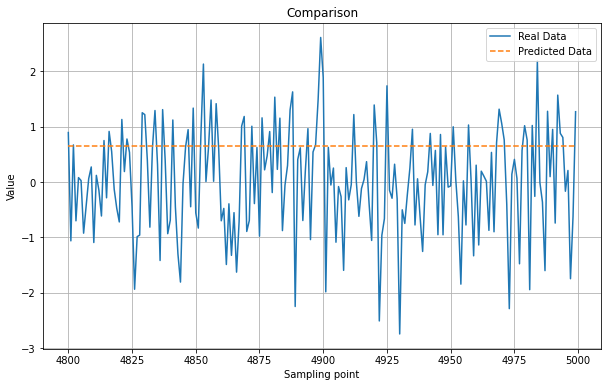

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Dense, Flatten, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import welch
import matplotlib.pyplot as plt

# 固定随机种子
np.random.seed(24)
tf.random.set_seed(25)

# 数据预处理
scaler = MinMaxScaler(feature_range=(-1, 1))
sampled_data = np.random.randn(5000)
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 30
X, y = [], []
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i + n_steps])
    y.append(train_data[i + n_steps])

X, y = np.array(X), np.array(y)

# 自定义频域损失函数
def spectral_loss(y_true, y_pred):
    fft_true = tf.signal.fft(tf.cast(y_true, tf.complex64))
    fft_pred = tf.signal.fft(tf.cast(y_pred, tf.complex64))
    spectral_loss = tf.reduce_mean(tf.square(tf.abs(fft_true) - tf.abs(fft_pred)))
    return 0.5 * tf.reduce_mean(tf.square(y_true - y_pred)) + 0.5 * spectral_loss

# 构建含有Attention的改进模型
def build_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 5, activation=None, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)

    # 添加Attention层
    attn_output = MultiHeadAttention(num_heads=2, key_dim=64)(x, x)
    x = tf.keras.layers.Add()([x, attn_output])  # 残差连接
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)

    x = Conv1D(128, 5, activation=None, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    return model

# 构建模型
model = build_attention_model((n_steps, 1))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=spectral_loss)

# 设置学习率调度器和早停机制
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

# 训练模型
epochs = 200
X = X.reshape((X.shape[0], X.shape[1], 1))
history = model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, callbacks=[early_stopping, lr_scheduler], verbose=1)

# 预测和评价
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))
predicted_points = []
for _ in range(200):
    predicted = model.predict(X_input, verbose=0)
    predicted_points.append(predicted[0][0])
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
